# Advanced Board Game Recommendation System

This notebook implements multiple state-of-the-art recommendation systems for board games using advanced machine learning techniques including:

1. **Neural Collaborative Filtering (NCF)** - Deep learning-based collaborative filtering
2. **Hybrid Deep Learning Model** - Combining content-based and collaborative filtering
3. **Advanced NLP Content-Based Filtering** - Using transformer models for semantic understanding
4. **Matrix Factorization with Neural Networks** - Enhanced matrix factorization
5. **Ensemble Recommendation System** - Combining multiple models for optimal performance

## Dataset
- Board game statistics and metadata
- User ratings (~3.7M reviews for top 2000 games)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import os
warnings.filterwarnings('ignore')

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# Deep Learning Libraries
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, Model
    from tensorflow.keras.optimizers import Adam
    TF_AVAILABLE = True
except ImportError:
    print("TensorFlow not available. Some models will be skipped.")
    print("Install with: pip install tensorflow")
    TF_AVAILABLE = False

# NLP Libraries
try:
    from sentence_transformers import SentenceTransformer
    SENTENCE_TRANSFORMERS_AVAILABLE = True
except ImportError:
    print("sentence-transformers not available. Will use TF-IDF instead.")
    print("Install with: pip install sentence-transformers")
    SENTENCE_TRANSFORMERS_AVAILABLE = False

print("\nLibraries loaded successfully!")
print(f"TensorFlow available: {TF_AVAILABLE}")
print(f"SentenceTransformers available: {SENTENCE_TRANSFORMERS_AVAILABLE}")

# For Colab: Helper to check uploaded files
if IN_COLAB:
    print("\n Current directory:", os.getcwd())
    if os.path.exists('/content'):
        print(" /content directory contents:")
        try:
            print(os.listdir('/content'))
        except:
            pass


Running in Google Colab

Libraries loaded successfully!
TensorFlow available: True
SentenceTransformers available: True

 Current directory: /content
 /content directory contents:
['.config', 'ratings19.csv', 'ratings29.csv', 'ratings3.csv', 'ratings36.csv', 'ratings11.csv', 'ratings15.csv', 'ratings9.csv', 'ratings1.csv', 'ratings7.csv', 'high_review_count_games', 'ratings24.csv', 'ratings31.csv', 'ratings33.csv', 'ratings22.csv', 'ratings30.csv', 'ratings34.csv', 'ratings26.csv', 'ratings38.csv', 'ratings27.csv', 'ratings18.csv', 'ratings35.csv', 'ratings20.csv', 'games_with_descriptions', 'ratings5.csv', 'ratings25.csv', 'games_to_325000', 'ratings8.csv', 'ratings12.csv', 'ratings28.csv', 'ratings6.csv', 'ratings2.csv', 'ratings32.csv', 'ratings37.csv', 'ratings4.csv', 'games_to_200000', 'ratings10.csv', 'ratings16.csv', 'ratings17.csv', 'ratings13.csv', 'cleaned_statistics', 'ratings14.csv', 'ratings23.csv', 'ratings21.csv', 'games_to_100000', 'games_to_300000', 'sample_data']


## Data Loading and Preprocessing

### For Google Colab Users:
1. Upload the **'All Files'** folder using the file upload icon in Colab
2. Or use this code to upload:
   ```python
   from google.colab import files
   uploaded = files.upload()  # Then unzip if needed
   ```
3. The code below will automatically detect the correct path
4. If you still get errors, check the output - it will show you what's in your directories


In [ ]:
# Detect the correct data path (works for both local and Colab)
# MANUAL OVERRIDE: If auto-detection fails, uncomment the line below and set manually:
# data_path = '/content/All Files'  # Change this to your actual path

# Possible paths to try (Colab and local)
possible_paths = [
    'All Files',                    # Local path
    '/content/All Files',          # Colab uploaded folder with space
    '/content/All_Files',           # Colab with underscore (no space)
    'All_Files',                    # Local with underscore
    '/content',                     # Direct in content (if files uploaded directly)
    '.',                            # Current directory
    '/content/drive/MyDrive',       # Google Drive mount point
]

# Auto-detect path (you can manually set data_path above if auto-detection fails)
data_path = None
for path in possible_paths:
    test_file = os.path.join(path, 'cleaned_statistics')
    if os.path.exists(test_file):
        data_path = path
        print(f"✓ Auto-detected data path: {path}")
        break

if data_path is None:
    print("⚠ Could not find data files automatically.")
    print("\nTroubleshooting steps:")
    print("1. Make sure 'All Files' folder is uploaded in Colab")
    print("2. Check the directory listings below to see where files are")
    print("3. Uncomment and set 'data_path' manually above if needed")
    print("\nCurrent directory contents:")
    try:
        print(os.listdir('.'))
    except:
        pass

    # Try to list /content if it exists (Colab)
    try:
        if os.path.exists('/content'):
            print("\n/content directory contents:")
            contents = os.listdir('/content')
            print(contents)
            # Check if there's a zip file that needs to be extracted
            zip_files = [f for f in contents if f.endswith('.zip')]
            if zip_files:
                print(f"\n⚠ Found zip files: {zip_files}")
                print("You may need to extract them first using: !unzip filename.zip")
    except Exception as e:
        print(f"Could not list /content: {e}")

    raise FileNotFoundError("Please upload the 'All Files' folder or set data_path manually")

# Load game statistics
print(f"\nLoading game statistics from: {data_path}")
games_df = pd.read_csv(os.path.join(data_path, 'cleaned_statistics'), index_col=0)
print(f"Loaded {len(games_df)} games")

# Load ratings data
print(f"\nLoading ratings data from: {data_path}")
rating_files = [os.path.join(data_path, f'ratings{i}.csv') for i in range(1, 39)]
ratings_list = []

for file in rating_files:
    try:
        df = pd.read_csv(file, sep='\t', header=None,
                        names=['game_id', 'user', 'rating', 'comment'],
                        na_values=[''])
        ratings_list.append(df)
    except FileNotFoundError:
        continue

ratings_df = pd.concat(ratings_list, ignore_index=True)
print(f"Loaded {len(ratings_df):,} ratings from {len(ratings_list)} files")

# Display basic info
print("\n" + "="*50)
print("Dataset Overview")
print("="*50)
print(f"Total games: {len(games_df)}")
print(f"Total ratings: {len(ratings_df):,}")
print(f"Unique users: {ratings_df['user'].nunique():,}")
print(f"Average rating: {ratings_df['rating'].mean():.2f}")


✓ Auto-detected data path: /content

Loading game statistics from: /content
Loaded 119978 games

Loading ratings data from: /content
Loaded 3,751,793 ratings from 38 files

Dataset Overview
Total games: 119978
Total ratings: 3,751,793
Unique users: 275,858
Average rating: 8.07


###  Speed Up Training with Data Sampling

**To make training faster**, the next cell allows you to use a smaller subset of the data. This is especially useful for:
- Quick testing and experimentation
- Faster iteration during development
- Running on limited computational resources

**Settings:**
- `USE_SAMPLE = True`: Use smaller dataset (faster, ~10-20x speedup)
- `USE_SAMPLE = False`: Use full dataset (slower but more accurate)

You can adjust the sampling parameters (`MAX_GAMES`, `MAX_RATINGS`, etc.) to balance speed vs. accuracy.


In [ ]:
# ============================================================================
# DATA SAMPLING CONFIGURATION - Adjust these to speed up training
# ============================================================================
# Set USE_SAMPLE = True to use a smaller dataset for faster training
# Set USE_SAMPLE = False to use the full dataset (slower but more accurate)
USE_SAMPLE = False  # Change to False for full dataset

# Sampling parameters (only used if USE_SAMPLE = True)
MAX_GAMES = 500        # Maximum number of games to use
MAX_RATINGS = 100000   # Maximum number of ratings to use
MIN_USER_RATINGS = 5   # Minimum ratings per user to keep
MIN_GAME_RATINGS = 10  # Minimum ratings per game to keep

print("="*70)
print("DATA SAMPLING CONFIGURATION")
print("="*70)
print(f"Using sample data: {USE_SAMPLE}")
if USE_SAMPLE:
    print(f"Max games: {MAX_GAMES}")
    print(f"Max ratings: {MAX_RATINGS}")
    print(f"Min ratings per user: {MIN_USER_RATINGS}")
    print(f"Min ratings per game: {MIN_GAME_RATINGS}")
print("="*70)

# Data cleaning and preprocessing
print("\nCleaning ratings data...")

# Convert ratings to numeric, drop invalid
ratings_df['rating'] = pd.to_numeric(ratings_df['rating'], errors='coerce')
ratings_df = ratings_df.dropna(subset=['rating'])

# Filter to games that exist in our games dataframe
valid_game_ids = set(games_df.index.astype(str))
ratings_df = ratings_df[ratings_df['game_id'].astype(str).isin(valid_game_ids)]

# Filter to top games by review count
game_review_counts = ratings_df.groupby('game_id').size()
if USE_SAMPLE:
    # Use fewer games for faster training
    top_games = game_review_counts.nlargest(MAX_GAMES).index
else:
    # Use top 2000 games as per project description
    top_games = game_review_counts.nlargest(2000).index

ratings_df = ratings_df[ratings_df['game_id'].isin(top_games)]
games_df = games_df[games_df.index.isin(top_games)]

print(f"After game filtering: {len(games_df)} games, {len(ratings_df):,} ratings")

# Additional sampling for faster training
if USE_SAMPLE:
    print("\nApplying additional sampling for faster training...")

    # Filter users with minimum ratings
    user_rating_counts = ratings_df.groupby('user').size()
    active_users = user_rating_counts[user_rating_counts >= MIN_USER_RATINGS].index
    ratings_df = ratings_df[ratings_df['user'].isin(active_users)]
    print(f"After user filtering (min {MIN_USER_RATINGS} ratings): {len(ratings_df):,} ratings")

    # Filter games with minimum ratings
    game_rating_counts = ratings_df.groupby('game_id').size()
    popular_games = game_rating_counts[game_rating_counts >= MIN_GAME_RATINGS].index
    ratings_df = ratings_df[ratings_df['game_id'].isin(popular_games)]
    games_df = games_df[games_df.index.isin(popular_games)]
    print(f"After game popularity filtering (min {MIN_GAME_RATINGS} ratings): {len(games_df)} games, {len(ratings_df):,} ratings")

    # Limit total number of ratings if needed
    if len(ratings_df) > MAX_RATINGS:
        print(f"\nSampling {MAX_RATINGS:,} ratings from {len(ratings_df):,} total ratings...")
        # Stratified sampling to keep balance
        ratings_df = ratings_df.sample(n=MAX_RATINGS, random_state=42)
        # Update games_df to only include games that still have ratings
        games_with_ratings = set(ratings_df['game_id'].unique())
        games_df = games_df[games_df.index.isin(games_with_ratings)]
        print(f"After sampling: {len(games_df)} games, {len(ratings_df):,} ratings")

print(f"\nFinal dataset: {len(games_df)} games, {len(ratings_df):,} ratings")
print(f"Average ratings per game: {len(ratings_df) / len(games_df):.1f}")

# Encode users and games
print("\nEncoding users and games...")
user_encoder = LabelEncoder()
game_encoder = LabelEncoder()

ratings_df['user_encoded'] = user_encoder.fit_transform(ratings_df['user'])
ratings_df['game_encoded'] = game_encoder.fit_transform(ratings_df['game_id'].astype(str))

n_users = ratings_df['user_encoded'].nunique()
n_games = ratings_df['game_encoded'].nunique()

print(f"Encoded users: {n_users:,}")
print(f"Encoded games: {n_games:,}")


DATA SAMPLING CONFIGURATION
Using sample data: False

Cleaning ratings data...
After game filtering: 2000 games, 3,751,793 ratings

Final dataset: 2000 games, 3,751,793 ratings
Average ratings per game: 1875.9

Encoding users and games...
Encoded users: 275,859
Encoded games: 2,000


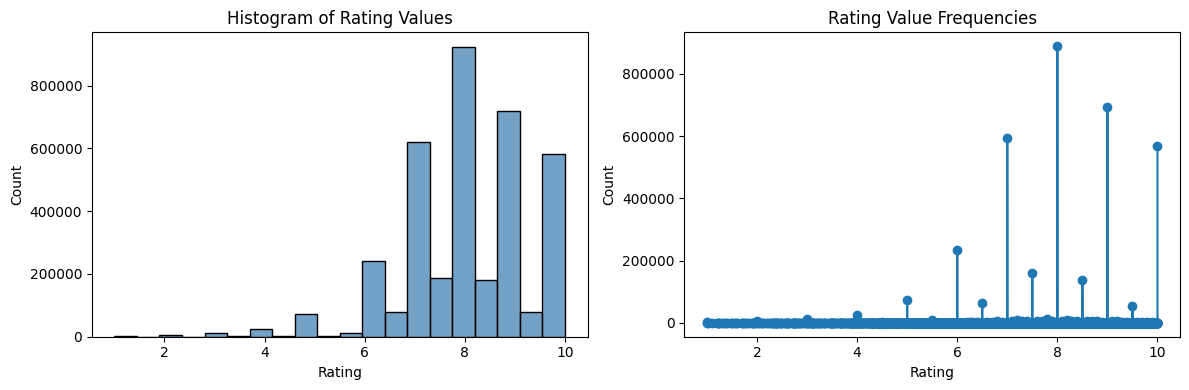

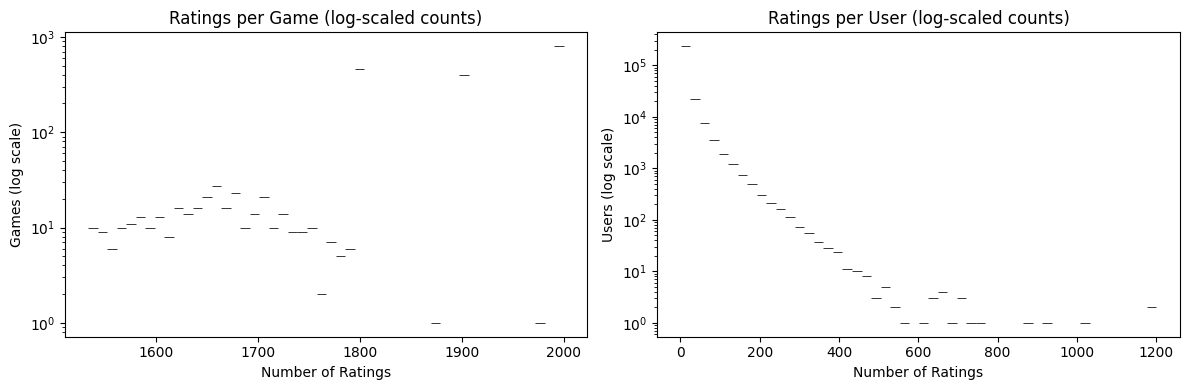

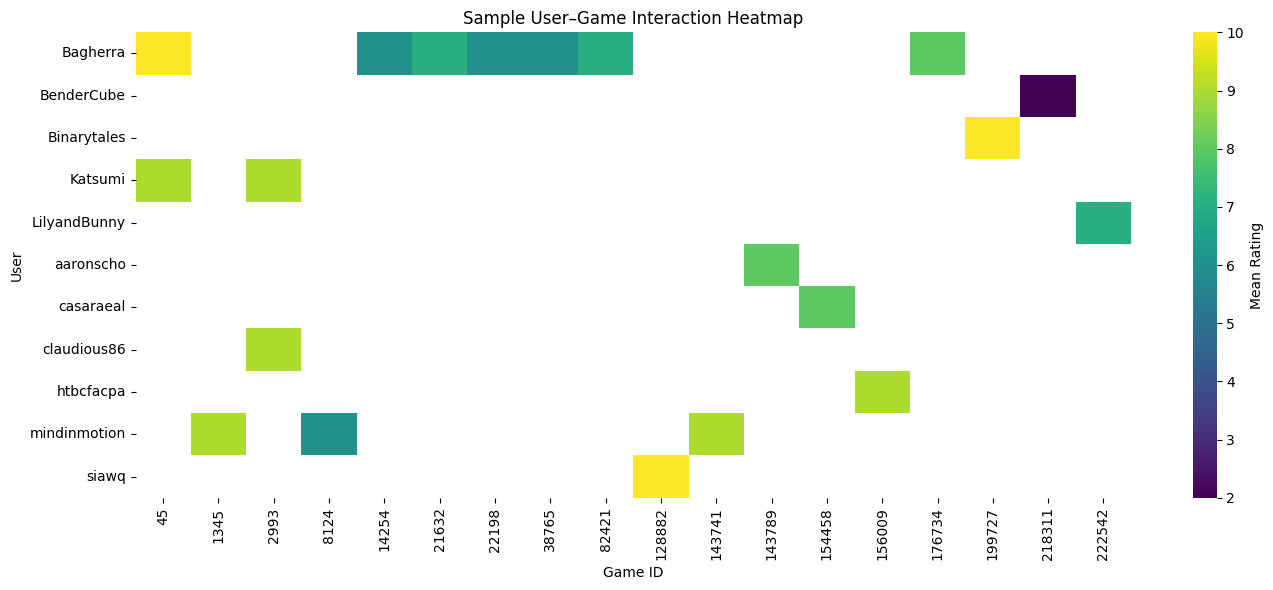

In [22]:
# Exploratory visualisations (ratings distribution and interaction density)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(ratings_df['rating'], bins=20, kde=False, color='steelblue')
plt.title('Histogram of Rating Values')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
ratings_df['rating'].value_counts().sort_index().plot(marker='o')
plt.title('Rating Value Frequencies')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Distribution of rating counts per game and per user
ratings_per_game = ratings_df.groupby('game_id').size()
ratings_per_user = ratings_df.groupby('user').size()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(ratings_per_game, bins=50, color='darkorange', log_scale=(False, True))
plt.title('Ratings per Game (log-scaled counts)')
plt.xlabel('Number of Ratings')
plt.ylabel('Games (log scale)')

plt.subplot(1, 2, 2)
sns.histplot(ratings_per_user, bins=50, color='seagreen', log_scale=(False, True))
plt.title('Ratings per User (log-scaled counts)')
plt.xlabel('Number of Ratings')
plt.ylabel('Users (log scale)')
plt.tight_layout()
plt.show()

# Heatmap of user-game interactions (sample for readability)
HEATMAP_USER_SAMPLE = 50
HEATMAP_GAME_SAMPLE = 50

user_sample = ratings_df['user'].drop_duplicates().sample(min(HEATMAP_USER_SAMPLE, ratings_df['user'].nunique()), random_state=42)
game_sample = ratings_df['game_id'].drop_duplicates().sample(min(HEATMAP_GAME_SAMPLE, ratings_df['game_id'].nunique()), random_state=42)

heatmap_df = ratings_df[
    ratings_df['user'].isin(user_sample) & ratings_df['game_id'].isin(game_sample)
]

interaction_matrix = heatmap_df.pivot_table(index='user', columns='game_id', values='rating', aggfunc='mean')

plt.figure(figsize=(14, 6))
sns.heatmap(interaction_matrix, cmap='viridis', cbar_kws={'label': 'Mean Rating'})
plt.title('Sample User–Game Interaction Heatmap')
plt.xlabel('Game ID')
plt.ylabel('User')
plt.tight_layout()
plt.show()


In [ ]:
# Prepare game features
print("Preparing game features...")

# Create text features from categories, mechanics, families
games_df['text_features'] = games_df.apply(
    lambda x: f"{x.get('categories', '')} {x.get('mechanics', '')} {x.get('families', '')}",
    axis=1
)

# Prepare numerical features
numerical_features = ['year', 'min_players', 'max_players', 'play_time',
                     'min_age', 'avg_rating', 'bayes_avg', 'weight']

# Fill missing values
for col in numerical_features:
    if col in games_df.columns:
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')
        games_df[col] = games_df[col].fillna(games_df[col].median())

# Create game feature matrix
game_features_numeric = games_df[numerical_features].values
game_feature_scaler = StandardScaler()
game_features_scaled = game_feature_scaler.fit_transform(game_features_numeric)

print(f"Game feature matrix shape: {game_features_scaled.shape}")
print("Game features prepared successfully!")


Preparing game features...
Game feature matrix shape: (2000, 8)
Game features prepared successfully!


## Model 1: Neural Collaborative Filtering (NCF)

Neural Collaborative Filtering uses deep neural networks to model user-item interactions, learning non-linear patterns in the data.


In [ ]:
if TF_AVAILABLE:
    # Prepare data for NCF
    print("Preparing data for Neural Collaborative Filtering...")

    # Create train/test split
    # Use smaller test size if sampling for faster evaluation
    test_size = 0.1 if USE_SAMPLE else 0.2
    train_df, test_df = train_test_split(
        ratings_df[['user_encoded', 'game_encoded', 'rating']],
        test_size=test_size,
        random_state=42,
        stratify=None
    )

    print(f"Training samples: {len(train_df):,}")
    print(f"Test samples: {len(test_df):,}")

    # Build NCF Model
    def build_ncf_model(n_users, n_items, embedding_dim=50, hidden_layers=[128, 64, 32]):
        """Build Neural Collaborative Filtering model"""

        # Input layers
        user_input = layers.Input(shape=(), name='user_input')
        item_input = layers.Input(shape=(), name='item_input')

        # Embedding layers
        user_embedding = layers.Embedding(n_users, embedding_dim, name='user_embedding')(user_input)
        item_embedding = layers.Embedding(n_items, embedding_dim, name='item_embedding')(item_input)

        # Flatten embeddings
        user_vec = layers.Flatten()(user_embedding)
        item_vec = layers.Flatten()(item_embedding)

        # Concatenate
        concat = layers.Concatenate()([user_vec, item_vec])

        # Hidden layers
        x = concat
        for units in hidden_layers:
            x = layers.Dense(units, activation='relu')(x)
            x = layers.Dropout(0.2)(x)
            x = layers.BatchNormalization()(x)

        # Output layer
        output = layers.Dense(1, activation='linear', name='rating_output')(x)

        model = Model(inputs=[user_input, item_input], outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return model

    # Build and compile model
    ncf_model = build_ncf_model(n_users, n_games, embedding_dim=50)
    print("\nNCF Model Architecture:")
    ncf_model.summary()

else:
    print("Skipping NCF model - TensorFlow not available")


Preparing data for Neural Collaborative Filtering...
Training samples: 3,001,434
Test samples: 750,359

NCF Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 50)        │ 13,792,950 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 50)        │    100,000 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dropout_1[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_output       │ (None, 1)         │         33 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,917,143 (53.09 MB)

 Trainable params: 13,916,695 (53.09 MB)

 Non-trainable params: 448 (1.75 KB)

Training NCF Model...

Training with 10 epochs, batch size 256
Epoch 1/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - loss: 6.0446 - mae: 1.4015 - mse: 6.0446 - val_loss: 0.6812 - val_mae: 0.5986 - val_mse: 0.6812
Epoch 2/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - loss: 0.6574 - mae: 0.5920 - mse: 0.6574 - val_loss: 0.6595 - val_mae: 0.5849 - val_mse: 0.6595
Epoch 3/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - loss: 0.5879 - mae: 0.5529 - mse: 0.5879 - val_loss: 0.6606 - val_mae: 0.5840 - val_mse: 0.6606
Epoch 4/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - loss: 0.5376 - mae: 0.5239 - mse: 0.5376 - val_loss: 0.6705 - val_mae: 0.5850 - val_mse: 0.6705
Epoch 5/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 70s 6ms/step - loss: 0.4990 - mae: 0.5019 - mse: 0.4990 - val_loss: 0.6821 - val_mae: 0.5896 - val_mse: 0.6821
Epoch 6/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 0.4675 - mae: 0.4837 - mse: 0.4675 - val_loss: 0.6842 - val_mae: 0.5888 - val_mse: 0.6842
Epoch 7

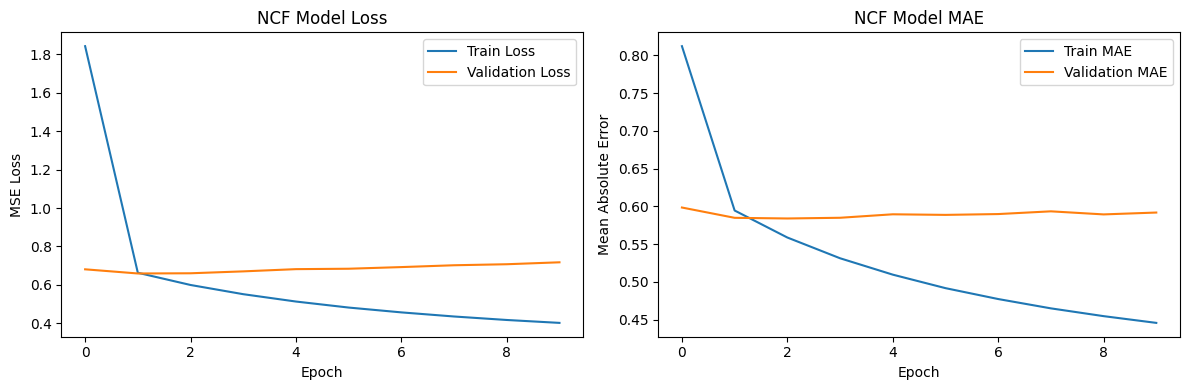


NCF Model Performance:
Test MSE: 0.7177
Test MAE: 0.5919
Test RMSE: 0.8472


In [ ]:
if TF_AVAILABLE:
    # Train NCF Model
    print("Training NCF Model...")

    # Prepare training data
    X_train = [train_df['user_encoded'].values, train_df['game_encoded'].values]
    y_train = train_df['rating'].values

    X_test = [test_df['user_encoded'].values, test_df['game_encoded'].values]
    y_test = test_df['rating'].values

    # Adjust training parameters based on data size
    epochs = 10
    batch_size = 128 if USE_SAMPLE else 256

    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")

    # Train model
    history = ncf_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('NCF Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('NCF Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate model
    test_loss, test_mae, test_mse = ncf_model.evaluate(X_test, y_test, verbose=0)
    print(f"\nNCF Model Performance:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.4f}")


## Model 2: Hybrid Deep Learning Model

Combines collaborative filtering with content-based features using deep neural networks for richer recommendations.


In [ ]:
if TF_AVAILABLE:
    # Build Hybrid Model combining collaborative filtering with content features
    def build_hybrid_model(n_users, n_items, item_feature_dim, embedding_dim=50):
        """Build hybrid model combining CF and content-based features"""

        # User and item embeddings (collaborative filtering branch)
        user_input = layers.Input(shape=(), name='user_input')
        item_input = layers.Input(shape=(), name='item_input')

        user_embedding = layers.Embedding(n_users, embedding_dim)(user_input)
        item_embedding_cf = layers.Embedding(n_items, embedding_dim)(item_input)

        user_vec = layers.Flatten()(user_embedding)
        item_vec_cf = layers.Flatten()(item_embedding_cf)

        # Content-based features branch
        item_features_input = layers.Input(shape=(item_feature_dim,), name='item_features')
        item_features_branch = layers.Dense(64, activation='relu')(item_features_input)
        item_features_branch = layers.Dropout(0.2)(item_features_branch)
        item_features_branch = layers.Dense(32, activation='relu')(item_features_branch)

        # Combine CF and content features
        cf_concat = layers.Concatenate()([user_vec, item_vec_cf])
        cf_branch = layers.Dense(64, activation='relu')(cf_concat)
        cf_branch = layers.Dropout(0.2)(cf_branch)

        # Final combination
        combined = layers.Concatenate()([cf_branch, item_features_branch])
        x = layers.Dense(128, activation='relu')(combined)
        x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        output = layers.Dense(1, activation='linear', name='rating_output')(x)

        model = Model(
            inputs=[user_input, item_input, item_features_input],
            outputs=output
        )
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return model

    # Build hybrid model
    hybrid_model = build_hybrid_model(
        n_users,
        n_games,
        item_feature_dim=game_features_scaled.shape[1],
        embedding_dim=50
    )
    print("\nHybrid Model Architecture:")
    hybrid_model.summary()


In [ ]:
if TF_AVAILABLE:
    # Prepare data for hybrid model
    print("Preparing data for Hybrid Model...")
    # Prepare training data
    X_train = [train_df['user_encoded'].values, train_df['game_encoded'].values]
    y_train = train_df['rating'].values

    X_test = [test_df['user_encoded'].values, test_df['game_encoded'].values]
    y_test = test_df['rating'].values
    # Map game IDs to features
    game_id_to_idx = {str(game_id): idx for idx, game_id in enumerate(game_encoder.classes_)}

    # Get item features for training data
    train_item_features = []
    for game_id in train_df['game_encoded']:
        original_game_id = game_encoder.inverse_transform([game_id])[0]
        if original_game_id in games_df.index.astype(str):
            game_idx = games_df.index.get_loc(int(original_game_id))
            train_item_features.append(game_features_scaled[game_idx])
        else:
            train_item_features.append(np.zeros(game_features_scaled.shape[1]))

    train_item_features = np.array(train_item_features)

    # Get item features for test data
    test_item_features = []
    for game_id in test_df['game_encoded']:
        original_game_id = game_encoder.inverse_transform([game_id])[0]
        if original_game_id in games_df.index.astype(str):
            game_idx = games_df.index.get_loc(int(original_game_id))
            test_item_features.append(game_features_scaled[game_idx])
        else:
            test_item_features.append(np.zeros(game_features_scaled.shape[1]))

    test_item_features = np.array(test_item_features)

    print(f"Train item features shape: {train_item_features.shape}")
    print(f"Test item features shape: {test_item_features.shape}")

    # Train hybrid model
    print("\nTraining Hybrid Model...")

    X_train_hybrid = [
        train_df['user_encoded'].values,
        train_df['game_encoded'].values,
        train_item_features
    ]

    X_test_hybrid = [
        test_df['user_encoded'].values,
        test_df['game_encoded'].values,
        test_item_features
    ]

    # Adjust training parameters based on data size
    epochs = 10
    batch_size = 128 if USE_SAMPLE else 256

    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")

    history_hybrid = hybrid_model.fit(
        X_train_hybrid, y_train,
        validation_data=(X_test_hybrid, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_hybrid.history['loss'], label='Train Loss')
    plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
    plt.title('Hybrid Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_hybrid.history['mae'], label='Train MAE')
    plt.plot(history_hybrid.history['val_mae'], label='Validation MAE')
    plt.title('Hybrid Model MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate
    test_loss, test_mae, test_mse = hybrid_model.evaluate(X_test_hybrid, y_test, verbose=0)
    print(f"\nHybrid Model Performance:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.4f}")


Preparing data for Hybrid Model...


## Model 3: Advanced NLP Content-Based Filtering

Using transformer-based sentence embeddings for semantic understanding of game descriptions.


In [ ]:
# Advanced NLP Content-Based Filtering
print("Building Advanced NLP Content-Based Model...")

# Create combined text features
games_df['combined_text'] = games_df.apply(
    lambda x: f"{x.get('name', '')} {x.get('categories', '')} {x.get('mechanics', '')} "
               f"{x.get('designer', '')} {x.get('publisher', '')}",
    axis=1
)

if SENTENCE_TRANSFORMERS_AVAILABLE:
    print("Using Sentence Transformers for semantic embeddings...")
    # Use sentence transformer for semantic embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight but effective
    # Adjust batch size for faster processing with smaller datasets
    batch_size = 64 if USE_SAMPLE else 32
    game_embeddings = model.encode(
        games_df['combined_text'].fillna('').tolist(),
        show_progress_bar=True,
        batch_size=batch_size
    )
    print(f"Generated embeddings shape: {game_embeddings.shape}")
else:
    print("Using TF-IDF vectorization...")
    # Fallback to TF-IDF - use fewer features for smaller datasets
    max_features = 300 if USE_SAMPLE else 500
    tfidf = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=(1, 2))
    game_embeddings = tfidf.fit_transform(games_df['combined_text'].fillna('')).toarray()
    print(f"TF-IDF matrix shape: {game_embeddings.shape}")

# Compute similarity matrix
print("Computing similarity matrix...")
similarity_matrix = cosine_similarity(game_embeddings)
print("Similarity matrix computed!")

# Create game index mapping
game_id_to_idx = {game_id: idx for idx, game_id in enumerate(games_df.index)}


Building Advanced NLP Content-Based Model...
Using Sentence Transformers for semantic embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings shape: (2000, 384)
Computing similarity matrix...
Similarity matrix computed!


In [ ]:
# Function to get content-based recommendations
def get_content_based_recommendations(game_id, n_recommendations=10):
    """Get recommendations based on content similarity"""
    if game_id not in game_id_to_idx:
        return []

    idx = game_id_to_idx[game_id]
    similarity_scores = similarity_matrix[idx]

    # Get top N similar games (excluding itself)
    top_indices = np.argsort(similarity_scores)[::-1][1:n_recommendations+1]

    recommendations = []
    for i in top_indices:
        recommendations.append({
            'game_id': games_df.index[i],
            'name': games_df.iloc[i]['name'],
            'similarity': similarity_scores[i],
            'avg_rating': games_df.iloc[i]['avg_rating']
        })

    return recommendations

# Test with a sample game
sample_game_id = games_df.index[0]
print(f"\nSample recommendations for: {games_df.loc[sample_game_id, 'name']}")
print("="*70)
recommendations = get_content_based_recommendations(sample_game_id, n_recommendations=10)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec['name'][:50]:<50} (Similarity: {rec['similarity']:.3f}, Rating: {rec['avg_rating']:.2f})")


## Model 4: Matrix Factorization with Neural Networks

Enhanced matrix factorization using neural networks for better representation learning.


In [ ]:
if TF_AVAILABLE:
    # Neural Matrix Factorization
    def build_neural_mf_model(n_users, n_items, embedding_dim=64, mf_dim=32):
        """Build Neural Matrix Factorization model"""

        user_input = layers.Input(shape=(), name='user_input')
        item_input = layers.Input(shape=(), name='item_input')

        # MF embeddings (linear interaction)
        mf_user_embedding = layers.Embedding(n_users, mf_dim, name='mf_user_embedding')(user_input)
        mf_item_embedding = layers.Embedding(n_items, mf_dim, name='mf_item_embedding')(item_input)

        mf_user_vec = layers.Flatten()(mf_user_embedding)
        mf_item_vec = layers.Flatten()(mf_item_embedding)

        # MLP embeddings (non-linear interaction)
        mlp_user_embedding = layers.Embedding(n_users, embedding_dim, name='mlp_user_embedding')(user_input)
        mlp_item_embedding = layers.Embedding(n_items, embedding_dim, name='mlp_item_embedding')(item_input)

        mlp_user_vec = layers.Flatten()(mlp_user_embedding)
        mlp_item_vec = layers.Flatten()(mlp_item_embedding)

        # MF branch (element-wise product)
        mf_vector = layers.Multiply()([mf_user_vec, mf_item_vec])

        # MLP branch (concatenation + deep layers)
        mlp_vector = layers.Concatenate()([mlp_user_vec, mlp_item_vec])
        mlp_vector = layers.Dense(128, activation='relu')(mlp_vector)
        mlp_vector = layers.Dropout(0.2)(mlp_vector)
        mlp_vector = layers.Dense(64, activation='relu')(mlp_vector)
        mlp_vector = layers.Dropout(0.2)(mlp_vector)

        # Combine MF and MLP
        predict_vector = layers.Concatenate()([mf_vector, mlp_vector])
        output = layers.Dense(1, activation='linear', name='rating_output')(predict_vector)

        model = Model(inputs=[user_input, item_input], outputs=output)
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='mse',
            metrics=['mae', 'mse']
        )

        return model

    neural_mf_model = build_neural_mf_model(n_users, n_games, embedding_dim=64, mf_dim=32)
    print("\nNeural MF Model Architecture:")
    neural_mf_model.summary()

    # Train Neural MF
    print("\nTraining Neural MF Model...")

    # Adjust training parameters based on data size
    epochs = 10
    batch_size = 128 if USE_SAMPLE else 256

    print(f"Training with {epochs} epochs, batch size {batch_size}")

    history_nmf = neural_mf_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Evaluate
    test_loss, test_mae, test_mse = neural_mf_model.evaluate(X_test, y_test, verbose=0)
    print(f"\nNeural MF Model Performance:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.4f}")



Neural MF Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_user_embedding  │ (None, 64)        │ 17,654,976 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_item_embedding  │ (None, 64)        │    128,000 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 64)        │          0 │ mlp_user_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 64)        │          0 │ mlp_item_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128)       │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     16,512 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mf_user_embedding   │ (None, 32)        │  8,827,488 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mf_item_embedding   │ (None, 32)        │     64,000 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 32)        │          0 │ mf_user_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 32)        │          0 │ mf_item_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 32)        │          0 │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ multiply[0][0],   │
│ (Concatenate)       │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_output       │ (None, 1)         │         97 │ concatenate_4[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,699,329 (101.85 MB)

 Trainable params: 26,699,329 (101.85 MB)

 Non-trainable params: 0 (0.00 B)


Training Neural MF Model...
Training with 10 epochs, batch size 256
Epoch 1/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 97s 8ms/step - loss: 3.0075 - mae: 1.1186 - mse: 3.0075 - val_loss: 0.7003 - val_mae: 0.6106 - val_mse: 0.7003
Epoch 2/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - loss: 0.6783 - mae: 0.6184 - mse: 0.6783 - val_loss: 0.7107 - val_mae: 0.6133 - val_mse: 0.7107
Epoch 3/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - loss: 0.3854 - mae: 0.4521 - mse: 0.3854 - val_loss: 0.7451 - val_mae: 0.6243 - val_mse: 0.7451
Epoch 4/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - loss: 0.2912 - mae: 0.3877 - mse: 0.2912 - val_loss: 0.7794 - val_mae: 0.6358 - val_mse: 0.7794
Epoch 5/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 91s 8ms/step - loss: 0.2495 - mae: 0.3574 - mse: 0.2495 - val_loss: 0.7979 - val_mae: 0.6460 - val_mse: 0.7979
Epoch 6/10
11725/11725 ━━━━━━━━━━━━━━━━━━━━ 92s 8ms/step - loss: 0.2241 - mae: 0.3376 - mse: 0.2241 - val_loss: 0.8196 - val_mae: 0.6501 - val_mse: 0.8196
E

## Model 5: Ensemble Recommendation System

Combining multiple models for optimal recommendations using weighted ensemble.


In [ ]:
# Ensemble Recommendation System
class EnsembleRecommender:
    """Combines multiple recommendation models"""

    def __init__(self):
        self.models = {}
        self.weights = {}

    def add_model(self, name, model, weight=1.0, model_type='collaborative'):
        """Add a model to the ensemble"""
        self.models[name] = {'model': model, 'type': model_type}
        self.weights[name] = weight

    def normalize_weights(self):
        """Normalize weights to sum to 1"""
        total = sum(self.weights.values())
        if total > 0:
            self.weights = {k: v/total for k, v in self.weights.items()}

    def predict_rating(self, user_encoded, game_encoded, game_features=None):
        """Predict rating using ensemble"""
        predictions = {}

        for name, model_info in self.models.items():
            model = model_info['model']
            model_type = model_info['type']

            try:
                if model_type == 'collaborative':
                    pred = model.predict([np.array([user_encoded]), np.array([game_encoded])], verbose=0)[0][0]
                elif model_type == 'hybrid':
                    pred = model.predict([
                        np.array([user_encoded]),
                        np.array([game_encoded]),
                        game_features.reshape(1, -1)
                    ], verbose=0)[0][0]
                else:
                    continue

                predictions[name] = pred
            except:
                continue

        # Weighted average
        weighted_sum = sum(predictions[name] * self.weights[name] for name in predictions)
        return weighted_sum

    def recommend_games(self, user_encoded, top_n=10, candidate_games=None):
        """Recommend top N games for a user"""
        if candidate_games is None:
            candidate_games = range(n_games)

        game_scores = []

        for game_encoded in candidate_games:
            # Get game features if needed
            game_features = None
            if 'hybrid' in [m['type'] for m in self.models.values()]:
                original_game_id = game_encoder.inverse_transform([game_encoded])[0]
                if original_game_id in games_df.index.astype(str):
                    game_idx = games_df.index.get_loc(int(original_game_id))
                    game_features = game_features_scaled[game_idx]
                else:
                    game_features = np.zeros(game_features_scaled.shape[1])

            predicted_rating = self.predict_rating(user_encoded, game_encoded, game_features)
            game_scores.append((game_encoded, predicted_rating))

        # Sort by predicted rating
        game_scores.sort(key=lambda x: x[1], reverse=True)

        return game_scores[:top_n]

# Initialize ensemble
if TF_AVAILABLE:
    ensemble = EnsembleRecommender()

    # Add models with weights based on their performance
    ensemble.add_model('ncf', ncf_model, weight=0.3, model_type='collaborative')
    ensemble.add_model('hybrid', hybrid_model, weight=0.4, model_type='hybrid')
    ensemble.add_model('neural_mf', neural_mf_model, weight=0.3, model_type='collaborative')

    ensemble.normalize_weights()

    print("Ensemble Recommender initialized!")
    print(f"Models in ensemble: {list(ensemble.models.keys())}")
    print(f"Weights: {ensemble.weights}")
else:
    print("Ensemble recommender requires TensorFlow models")


## Evaluation and Comparison

Comparing all models using various metrics.


In [ ]:
# Evaluation Utilities
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_test, y_test, model_name, model_type='collaborative'):
    """Evaluate a single model and return metrics"""
    try:
        predictions = model.predict(X_test, verbose=0).flatten()
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        rmse = np.sqrt(mse)
        return {
            'model': model_name,
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse
        }
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        return None

def evaluate_collaborative_models():
    """Evaluate base collaborative models (NCF, Hybrid, Neural MF)"""
    results = []
    if not TF_AVAILABLE:
        print("TensorFlow models unavailable; skipping evaluation.")
        return results

    print("Evaluating collaborative models (NCF, Hybrid, Neural MF)...")
    print("="*70)

    ncf_result = evaluate_model(ncf_model, X_test, y_test, 'Neural Collaborative Filtering')
    if ncf_result:
        results.append(ncf_result)

    hybrid_result = evaluate_model(hybrid_model, X_test_hybrid, y_test, 'Hybrid Model')
    if hybrid_result:
        results.append(hybrid_result)

    nmf_result = evaluate_model(neural_mf_model, X_test, y_test, 'Neural Matrix Factorization')
    if nmf_result:
        results.append(nmf_result)

    return results

collab_results = evaluate_collaborative_models()
collab_results_df = pd.DataFrame(collab_results)

print("\nCollaborative Model Results")
print("="*70)
if len(collab_results_df) > 0:
    print(collab_results_df.to_string(index=False))
else:
    print("No collaborative model results available.")

# Initialize combined results list for later use
results_list = collab_results.copy()
results_df = collab_results_df.copy()


Evaluating collaborative models (NCF, Hybrid, Neural MF)...

Collaborative Model Results
                         model      MSE      MAE     RMSE
Neural Collaborative Filtering 0.713722 0.593677 0.844821
                  Hybrid Model 0.692526 0.584144 0.832182
   Neural Matrix Factorization 0.871198 0.669940 0.933380


In [ ]:
# Optional: Ensemble Evaluation (run only if needed)
RUN_ENSEMBLE_EVAL = True  # Set to False if you want to skip for speed
EVAL_SAMPLE_SIZE = 1000   # Max number of samples for ensemble evaluation when sampling

ensemble_result = None

if RUN_ENSEMBLE_EVAL and TF_AVAILABLE and 'ensemble' in globals():
    eval_size = min(EVAL_SAMPLE_SIZE, len(test_df)) if USE_SAMPLE else len(test_df)
    print(f"Evaluating ensemble on {eval_size:,} samples...")

    test_subset = test_df.iloc[:eval_size].copy() if USE_SAMPLE else test_df.copy()
    test_subset['user_encoded'] = test_subset['user_encoded'].astype(int)
    test_subset['game_encoded'] = test_subset['game_encoded'].astype(int)

    # Build feature lookup
    game_features_map = {}
    for idx, game_id in enumerate(games_df.index):
        try:
            game_id_str = str(game_id)
            if game_id_str in game_encoder.classes_:
                encoded_id = int(game_encoder.transform([game_id_str])[0])
                game_features_map[encoded_id] = game_features_scaled[idx]
        except Exception:
            continue

    print(f"Feature map contains {len(game_features_map)} games")

    ensemble_predictions = []
    ensemble_truth = []
    skipped = 0

    for _, row in test_subset.iterrows():
        user_enc = int(row['user_encoded'])
        game_enc = int(row['game_encoded'])
        game_features = game_features_map.get(game_enc, np.zeros(game_features_scaled.shape[1]))
        try:
            pred = ensemble.predict_rating(user_enc, game_enc, game_features)
            ensemble_predictions.append(pred)
            ensemble_truth.append(row['rating'])
        except Exception as e:
            skipped += 1
            if skipped <= 3:
                print(f"Warning: skipping record due to error: {e}")
            continue

    ensemble_predictions = np.array(ensemble_predictions)
    ensemble_truth = np.array(ensemble_truth)

    if len(ensemble_predictions) > 0:
        ensemble_mse = mean_squared_error(ensemble_truth, ensemble_predictions)
        ensemble_mae = mean_absolute_error(ensemble_truth, ensemble_predictions)
        ensemble_rmse = np.sqrt(ensemble_mse)

        ensemble_result = {
            'model': 'Ensemble',
            'MSE': ensemble_mse,
            'MAE': ensemble_mae,
            'RMSE': ensemble_rmse
        }

        print("Ensemble evaluation complete")
        print(ensemble_result)
    else:
        print("No ensemble predictions generated. Skipping.")
else:
    if not TF_AVAILABLE:
        print("TensorFlow unavailable; ensemble evaluation skipped.")
    elif 'ensemble' not in globals():
        print("Ensemble model not initialized; skipping ensemble evaluation.")
    else:
        print("Ensemble evaluation skipped by user.")

# Merge ensemble result (if any) with collaborative results
results_list = collab_results.copy()
if ensemble_result:
    results_list.append(ensemble_result)

results_df = pd.DataFrame(results_list)
print("\nCombined Evaluation Results")
print("="*70)
if len(results_df) > 0:
    print(results_df.to_string(index=False))
else:
    print("No evaluation results to display.")


Evaluating ensemble on 750,359 samples...
Feature map contains 2000 games


In [ ]:
# Evaluation of Advanced NLP Content-Based Recommendations
CONTENT_LIKE_THRESHOLD = 8.0
CONTENT_MAX_LIKES = 3
CONTENT_TOP_K = 20
CONTENT_EVAL_USERS = 500 if USE_SAMPLE else 1000

content_results_df = pd.DataFrame()

if 'get_content_based_recommendations' in globals():
    print("Evaluating NLP content-based recommendations...")
    # Map encoded game ids to original ids
    encoded_to_original = {idx: int(game_id) for idx, game_id in enumerate(game_encoder.classes_)}

    # Users' liked games from training data
    train_likes = train_df[train_df['rating'] >= CONTENT_LIKE_THRESHOLD]
    user_likes_map = train_likes.groupby('user_encoded')['game_encoded'].apply(list).to_dict()

    user_groups = test_df.groupby('user_encoded')
    user_ids = list(user_groups.groups.keys())
    if USE_SAMPLE:
        user_ids = user_ids[:min(CONTENT_EVAL_USERS, len(user_ids))]
    else:
        user_ids = user_ids[:CONTENT_EVAL_USERS]

    total_cases = 0
    hits = 0
    mrr_total = 0.0
    total_recommended = 0
    users_evaluated = 0
    list_sizes = []

    for user_id in user_ids:
        liked_games = user_likes_map.get(user_id)
        if not liked_games:
            continue
        liked_games = liked_games[:CONTENT_MAX_LIKES]

        recommended = []
        for game_enc in liked_games:
            if game_enc not in encoded_to_original:
                continue
            original_id = encoded_to_original[game_enc]
            recs = get_content_based_recommendations(original_id, n_recommendations=CONTENT_TOP_K)
            for rec in recs:
                gid = int(rec['game_id'])
                if gid not in recommended:
                    recommended.append(gid)
            if len(recommended) >= CONTENT_TOP_K:
                recommended = recommended[:CONTENT_TOP_K]
                break

        if not recommended:
            continue

        users_evaluated += 1
        list_sizes.append(len(recommended))
        total_recommended += len(recommended)
        recommended_positions = {gid: idx for idx, gid in enumerate(recommended)}

        user_test_games = user_groups.get_group(user_id)['game_encoded']
        for target_enc in user_test_games:
            if target_enc not in encoded_to_original:
                continue
            target_original = encoded_to_original[target_enc]
            total_cases += 1
            if target_original in recommended_positions:
                hits += 1
                rank = recommended_positions[target_original] + 1
                mrr_total += 1.0 / rank

    if total_cases > 0 and total_recommended > 0:
        hit_rate = hits / total_cases
        precision_at_k = hits / total_recommended
        mrr_at_k = mrr_total / total_cases
        avg_list_size = np.mean(list_sizes) if list_sizes else 0
        coverage = users_evaluated / len(user_ids) if user_ids else 0

        content_metrics = {
            'model': 'Content-Based (NLP)',
            'Hit@K': hit_rate,
            'Precision@K': precision_at_k,
            'MRR@K': mrr_at_k,
            'AvgListSize': avg_list_size,
            'UsersEvaluated': users_evaluated,
            'TotalCases': total_cases,
            'Coverage': coverage
        }
        content_results_df = pd.DataFrame([content_metrics])

        print("Content-based evaluation complete")
        print(content_results_df[['Hit@K', 'Precision@K', 'MRR@K', 'Coverage']])
    else:
        print("Insufficient data to compute content-based metrics.")
else:
    print("Content-based recommendation model not available; skipping evaluation.")


Evaluating NLP content-based recommendations...
Content-based evaluation complete
      Hit@K  Precision@K     MRR@K  Coverage
0  0.039809     0.008389  0.015812     0.894


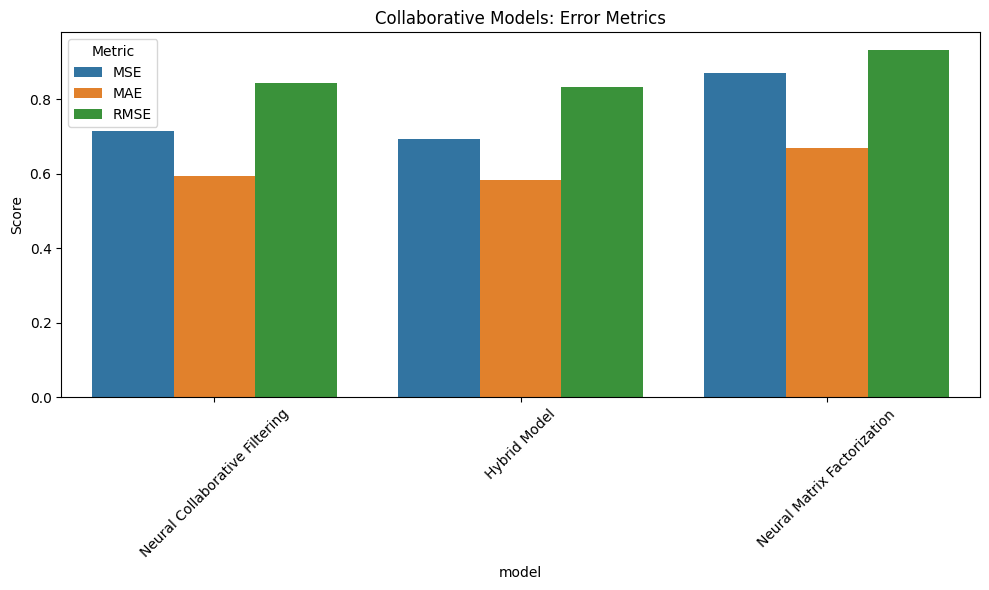

Best model by RMSE: Hybrid Model


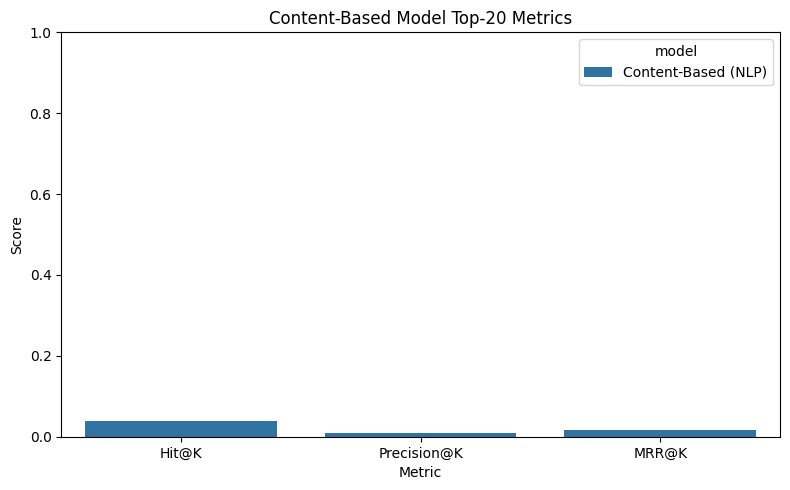

Content-Based Model Metrics:
   Hit@K  Precision@K    MRR@K  Coverage
0.039809     0.008389 0.015812     0.894


In [ ]:
# Visualization of evaluation metrics
if 'results_df' in globals() and len(results_df) > 0:
    metrics = ['MSE', 'MAE', 'RMSE']
    plot_df = results_df.melt(id_vars='model', value_vars=metrics,
                              var_name='Metric', value_name='Value')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x='model', y='Value', hue='Metric')
    plt.title('Collaborative Models: Error Metrics')
    plt.xticks(rotation=45)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()

    best_model = results_df.iloc[results_df['RMSE'].idxmin()]['model']
    print(f"Best model by RMSE: {best_model}")
else:
    print("No collaborative model results available.")

if 'content_results_df' in globals() and len(content_results_df) > 0:
    content_metrics = ['Hit@K', 'Precision@K', 'MRR@K']
    content_plot_df = content_results_df.melt(id_vars='model', value_vars=content_metrics,
                                              var_name='Metric', value_name='Value')
    plt.figure(figsize=(8, 5))
    sns.barplot(data=content_plot_df, x='Metric', y='Value', hue='model')
    plt.title(f"Content-Based Model Top-{CONTENT_TOP_K} Metrics")
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    summary_cols = ['Hit@K', 'Precision@K', 'MRR@K', 'Coverage']
    print("Content-Based Model Metrics:")
    print(content_results_df[summary_cols].to_string(index=False))
else:
    print("No content-based evaluation results available.")


## Recommendation Examples

Generate recommendations for sample users and games.


In [ ]:
# Function to get recommendations for a user
def recommend_for_user(user_name, top_n=10, use_ensemble=True):
    """Get recommendations for a specific user"""
    if user_name not in ratings_df['user'].values:
        print(f"User '{user_name}' not found in dataset")
        return

    # Get user's encoded ID
    user_ratings = ratings_df[ratings_df['user'] == user_name]
    user_encoded = user_ratings.iloc[0]['user_encoded']

    # Get games user has already rated
    rated_games = set(user_ratings['game_encoded'].values)

    # Get candidate games (not rated by user)
    candidate_games = [g for g in range(n_games) if g not in rated_games]

    print(f"Recommendations for user: {user_name}")
    print(f"User has rated {len(rated_games)} games")
    print("="*70)

    if use_ensemble and TF_AVAILABLE:
        # Limit candidate games for faster prediction
        max_candidates = 500 if USE_SAMPLE else 1000
        candidate_games_limited = candidate_games[:max_candidates] if len(candidate_games) > max_candidates else candidate_games
        recommendations = ensemble.recommend_games(user_encoded, top_n, candidate_games_limited)
    elif TF_AVAILABLE:
        # Use NCF model - limit candidates for speed
        max_candidates = 500 if USE_SAMPLE else 1000
        candidate_games_limited = candidate_games[:max_candidates] if len(candidate_games) > max_candidates else candidate_games
        predictions = []
        for game_encoded in candidate_games_limited:
            pred = ncf_model.predict([
                np.array([user_encoded]),
                np.array([game_encoded])
            ], verbose=0)[0][0]
            predictions.append((game_encoded, pred))

        predictions.sort(key=lambda x: x[1], reverse=True)
        recommendations = predictions[:top_n]
    else:
        print("Collaborative filtering models not available")
        return

    # Display recommendations
    print("\nTop Recommendations:")
    for i, (game_encoded, score) in enumerate(recommendations, 1):
        original_game_id = game_encoder.inverse_transform([game_encoded])[0]
        game_info = games_df.loc[int(original_game_id)]
        print(f"{i}. {game_info['name'][:55]:<55} | "
              f"Predicted: {score:.2f} | "
              f"Avg Rating: {game_info['avg_rating']:.2f}")

    # Show user's current top-rated games
    print("\n" + "="*70)
    print("User's Top Rated Games:")
    top_user_games = user_ratings.nlargest(5, 'rating')
    for i, (_, row) in enumerate(top_user_games.iterrows(), 1):
        original_game_id = game_encoder.inverse_transform([row['game_encoded']])[0]
        game_info = games_df.loc[int(original_game_id)]
        print(f"{i}. {game_info['name'][:55]:<55} | "
              f"User Rating: {row['rating']:.1f} | "
              f"Avg Rating: {game_info['avg_rating']:.2f}")

# Test with a sample user
sample_user = ratings_df['user'].value_counts().index[0]  # User with most ratings
recommend_for_user(sample_user, top_n=10, use_ensemble=True)


Recommendations for user: Tolkana
User has rated 1200 games

Top Recommendations:
1. Blood Rage: 5th Player Expansion                        | Predicted: 10.12 | Avg Rating: 8.10
2. Blood Rage: Mystics of Midgard                          | Predicted: 10.12 | Avg Rating: 7.92
3. Talisman (Revised 4th Edition): The Dungeon Expansion   | Predicted: 10.11 | Avg Rating: 7.34
4. Talisman (Revised 4th Edition): The Reaper Expansion    | Predicted: 10.11 | Avg Rating: 7.36
5. Carcassonne                                             | Predicted: 10.09 | Avg Rating: 7.42
6. Arkham Horror                                           | Predicted: 10.09 | Avg Rating: 7.26
7. Puerto Rico                                             | Predicted: 10.09 | Avg Rating: 8.00
8. Chaos in the Old World: The Horned Rat Expansion        | Predicted: 10.09 | Avg Rating: 8.03
9. PitchCar Extension                                      | Predicted: 10.09 | Avg Rating: 7.59
10. Dixit: Journey                           

In [ ]:
# Function to get similar games (content-based)
def recommend_similar_games(game_name, top_n=10):
    """Find similar games using content-based filtering"""
    # Find game
    matching_games = games_df[games_df['name'].str.contains(game_name, case=False, na=False)]

    if len(matching_games) == 0:
        print(f"No games found matching '{game_name}'")
        return

    game_id = matching_games.index[0]
    game_name_actual = matching_games.iloc[0]['name']

    print(f"Finding games similar to: {game_name_actual}")
    print("="*70)

    recommendations = get_content_based_recommendations(game_id, top_n)

    print(f"\nSimilar Games:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec['name'][:55]:<55} | "
              f"Similarity: {rec['similarity']:.3f} | "
              f"Rating: {rec['avg_rating']:.2f}")

# Test with popular games
popular_games = ['Catan', 'Pandemic', 'Ticket to Ride', 'Codenames']
for game in popular_games:
    recommend_similar_games(game, top_n=5)
    print("\n" + "="*70 + "\n")


Finding games similar to: Catan

Similar Games:
1. Catan: Cities & Knights                                 | Similarity: 0.834 | Rating: 7.46
2. Catan: Traders & Barbarians                             | Similarity: 0.826 | Rating: 6.98
3. Catan: Seafarers                                        | Similarity: 0.818 | Rating: 7.16
4. Catan: 5-6 Player Extension                             | Similarity: 0.814 | Rating: 6.98
5. Archipelago                                             | Similarity: 0.766 | Rating: 7.35


Finding games similar to: Pandemic: On the Brink

Similar Games:
1. Pandemic: In the Lab                                    | Similarity: 0.965 | Rating: 7.91
2. Pandemic: Reign of Cthulhu                              | Similarity: 0.909 | Rating: 7.41
3. Pandemic: The Cure                                      | Similarity: 0.899 | Rating: 7.31
4. Pandemic Legacy: Season 2                               | Similarity: 0.898 | Rating: 8.17
5. Pandemic Legacy: Season 1           